## Hypothesis tests for the cryptocurrency market

### Collecting market prices variations from stock indices

$ pip install googlefinance.client

In [1]:
from googlefinance.client import get_price_data
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def collect_market(stock, period='1Y', frequency='MONTHLY'):
    """ Given a stock index, a period and a frequency, collects the daily closing price of the market
    Args:
        stock (string) : stock symbol (ex: 'AAPL')
        period (string) : period (ex: '1Y' = 1 year, '6M' = 6 months, '1d' = 1 day)
        frequency (string) : frequency of data ('DAILY' = per day, 'MONTHLY' = per month)
    Returns:
        prices (pandas.DataFrame) : daily closing prices of the corresponding market
    """
    param = {}
    param['q'] = stock
    param['i'] = '86400' # Daily interval
    param['p'] = period
    prices = get_price_data(param)
    if frequency == 'MONTHLY': # Compute the mean by month if frequency is MONTHLY
        prices['date'] = prices.index.map(lambda x: x.strftime('%Y-%m'))
        prices = prices.groupby('date').mean()
    return prices['Close']

Example with BTCUSD:

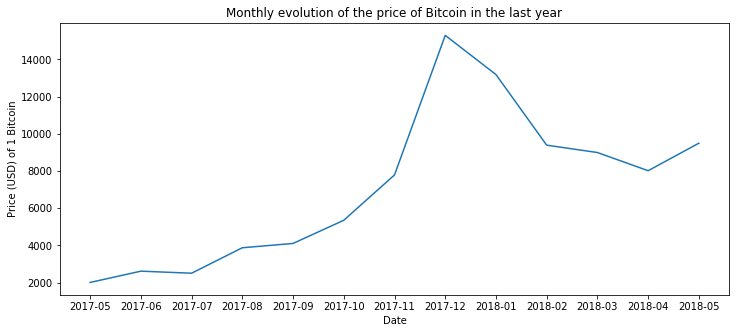

In [3]:
btc_prices = collect_market('BTCUSD')
plt.figure(figsize=(12, 5))
plt.xlabel('Date')
plt.ylabel('Price (USD) of 1 Bitcoin')
plt.title('Monthly evolution of the price of Bitcoin in the last year')
plt.plot(btc_prices);

In [4]:
def prices_variations(prices):
    """ Given prices from a market, compute the variations between one unit of time and its predecessor
    Args:
        prices (pandas.DataFrame) : daily closing prices of a market
    Returns:
        variations (numpy.ndarray) : percentage variations between two units of time 
    """
    return np.array([100*(x-prices[i-1])/prices[i-1] for i, x in enumerate(prices)][1:])

Example with BTCUSD:

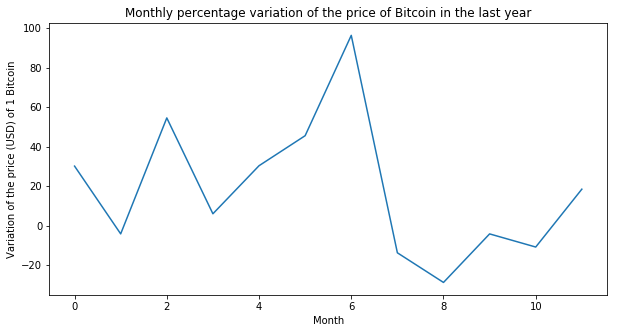

In [5]:
btc_var = prices_variations(btc_prices)
plt.figure(figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Variation of the price (USD) of 1 Bitcoin')
plt.title('Monthly percentage variation of the price of Bitcoin in the last year')
plt.plot(btc_var);

Now, in the same way, let's collect the variations from other important markets:
* Technology: NDAQ
* Renewable energy: OSPTX
* Real estate: DJUSRE
* Crude oil: CL1
* Gold: HUI

In [6]:
def collect_variations(stocks, period='1Y', frequency='MONTHLY'):
    """ Given a list of stock indexes, a period and a frequency, collects the variations of the markets
    Args:
        stocks (list) : list of stock symbols (ex: ['NDAQ', 'OSPTX'])
        period (string) : period (ex: '1Y' = 1 year, '6M' = 6 months, '1d' = 1 day)
        frequency (string) : frequency of data ('DAILY' = per day, 'MONTHLY' = per month)
    Returns:
        stocks_var (dict) : variations of each market
    """
    stocks_var = {}
    for stock in stocks:
        prices = collect_market(stock, period, frequency)
        stocks_var[stock] = prices_variations(prices)
    return stocks_var

In [7]:
stocks = ['NDAQ', 'OSPTX', 'DJUSRE', 'CL1', 'HUI'] # List of stock indexes
stocks_var = collect_variations(stocks) # Collect the variations of each market

### Tests of Pearson's correlation

Pearson's correlation coefficient is a measure of the linear correlation between two variables $X$ and $Y$. It can be conducted in six steps.

#### Step 1: specify the null hypothesis and the alternative hypothesis

$H_0: \rho = 0 \qquad H_1: \rho \neq 0$

#### Step 2: choose a significance level

$\alpha = 0.05$

#### Step 3: compute the sample value of Pearson's correlation coefficient

In [8]:
def pearson_coefficient(X, Y):
    """ Computes the Pearson's correlation coefficient
    Args:
        X (list) : values of the first sample
        Y (list) : values of the second sample
    Returns:
        r (float) : Pearson's correlation coefficient
    """
    return np.divide(np.sum(X*Y)-np.sum(X)*np.sum(Y)/len(X),
                     np.sqrt((np.sum(X**2)-np.sum(X)**2/len(X))*(np.sum(Y**2)-np.sum(Y)**2/len(X))))

#### Step 4: compute the T-score

In [9]:
def t_score(sample_size, r):
    """ Computes the T-score
    Args:
        sample_size (int) : size of the sample
        r (float) : Pearson's correlation coefficient
    Returns:
        t (float) : T-score
    """
    return np.divide(r*np.sqrt(sample_size-2), np.sqrt(1-r**2)) if abs(r) != 1 else float('Inf')

#### Step 5: compute the p-value

In [10]:
def p_value(t, df):
    """ Given a T-score and a degree of freedom, computes the p-value
    Args:
        t (float) : T-score
        df (int) : degree of freedom
    Returns:
        p (float) : p-value
    """
    return stats.t.sf(np.abs(t), df)*2

#### Step 6: conclude

If the p-value from Step 5 is less than the significance level of Step 2, then the correlation is significant and we reject $H_0$. Otherwise, there is no strong evidence of linear correlation between $X$ and $Y$ and we do not reject $H_0$.

#### Summarization of the six steps in one function

In [11]:
def pearson_test(X, Y, alpha=0.05):
    """ Conduct a Pearson's correlation test
    Args:
        X (list) : values of first sample
        Y (list) : values of second sample
        alpha (float) : significance level
    """
    r = pearson_coefficient(X, Y)
    t = t_score(len(X), r)
    p = p_value(t, len(X) - 2)
    is_significant = p < alpha
    print('alpha = {} ; r = {} ; t = {} ; p = {} ; correlation = {} ; reject H0 = {}'
          .format(alpha, round(r, 3), round(t, 3), round(p, 3), is_significant, is_significant))

To make sure that our test can result in significant correlation, we can test it with two identical markets.

In [12]:
pearson_test(btc_var, btc_var)

alpha = 0.05 ; r = 1.0 ; t = inf ; p = 0.0 ; correlation = True ; reject H0 = True


### Correlation between cryptomarket and other markets

Now, let's conduct the Pearson's test on the cryptomarket and the other markets!

In [13]:
for stock in stocks:
    print('-- Test on {}'.format(stock))
    pearson_test(btc_var, stocks_var[stock])
    print()

-- Test on NDAQ
alpha = 0.05 ; r = 0.109 ; t = 0.347 ; p = 0.736 ; correlation = False ; reject H0 = False

-- Test on OSPTX
alpha = 0.05 ; r = 0.375 ; t = 1.28 ; p = 0.229 ; correlation = False ; reject H0 = False

-- Test on DJUSRE
alpha = 0.05 ; r = 0.417 ; t = 1.45 ; p = 0.178 ; correlation = False ; reject H0 = False

-- Test on CL1
alpha = 0.05 ; r = 0.022 ; t = 0.069 ; p = 0.946 ; correlation = False ; reject H0 = False

-- Test on HUI
alpha = 0.05 ; r = -0.018 ; t = -0.058 ; p = 0.955 ; correlation = False ; reject H0 = False



With a 95% confidence level, we conclude that there was no significant linear correlation between the Bitcoin market and the other markets in the last year.

### Correlation between different cryptocurrencies

While we couldn't find a strong correlation between the Bitcoin market and the other markets, it is likely that there are correlations between different cryptocurrencies market. In this section, we're going to build a heatmap showing how cryptocurrencies are correlated to each other based on Pearson's coefficient. The cryptocurrencies we're interested in are:

* BCH: Bitcoin Cash
* ETH: Ethereum
* LTC: Litecoin
* NEO: NEO (formerly ANS)
* EOS: EOSIO

In [14]:
def collect_coefficients(stocks_var):
    """ Given a list of stocks variations, compute the Pearson's correlation coefficient for each pair of stocks
    Args:
        stocks_var (dict) : variations of each market with n keys
    Returns:
        coeff (numpy.ndarray) : n*n matrix of Pearson's correlation coefficient
    """
    stocks = list(stocks_var.keys())
    return np.array([[pearson_coefficient(stocks_var[stock], stocks_var[other]) for other in stocks]
                     for stock in stocks])

In [15]:
crypto = ['BTCUSD', 'BCH', 'ETH', 'LTC', 'NEO', 'EOS'] # List of cryptocurrencies
crypto_var = collect_variations(crypto) # Collect the variations of each cryptocurrency
coeff = collect_coefficients(crypto_var) # Collect the Pearson's coefficients

To clearly visualize the correlations between the cryptocurrencies markets, let's display the coefficients in a heatmap.

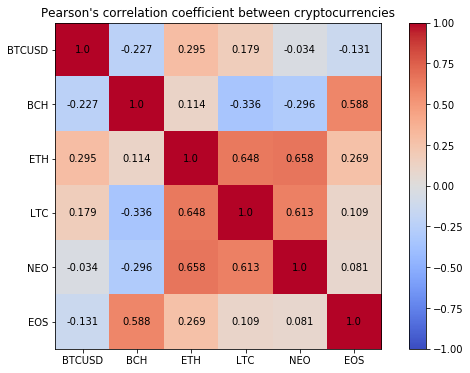

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(coeff, vmin=-1, vmax=1, cmap="coolwarm")
ax.set_xticks(np.arange(len(crypto)))
ax.set_yticks(np.arange(len(crypto)))
ax.set_xticklabels(crypto)
ax.set_yticklabels(crypto)
for row in range(len(coeff)):
    for col in range(len(coeff)):
        ax.text(col, row, round(coeff[row][col], 3), ha='center', va='center')
ax.set_title("Pearson's correlation coefficient between cryptocurrencies")
ax.figure.colorbar(im, ax=ax)
plt.show()

With a 95% confidence level, we can say that there is a positive linear correlation between ETH, LTC and NEO.

### References

* Google Finance API: https://pypi.org/project/googlefinance.client/
* Pearson's correlation test: http://davidmlane.com/hyperstat/B62223.html
* How to perform correlation analysis on cryptocurrencies in Google Sheets: https://spreadstreet.io/blog/cryptocurrency-correlation-tool/
* Creating annotated heatmaps : https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html